In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from cmcrameri import cm as  cmc
import matplotlib as mpl
import pandas as pd
import xarray as xr
import sys
sys.path.insert(0, '../lib')
sys.path.insert(0, '../src')

import ml_estimation as ml
import model1_plots as mp
import model1_explore as me
import model1 as mod1
from scipy.stats import norm, beta
from statsmodels.base.model import GenericLikelihoodModel
import palettable as pal

import Utilities as util


In [21]:
loc_model = '../mod/model1/sim/'
loc_fig = '../fig/model1/sim/'

# read data
# explorative
# 0. overview
ds_c = xr.open_dataset(loc_model + 'expl_hist_clouds.nc')
T_total = pd.read_csv(loc_model + 'expl_transition_ctypes.csv', index_col = 0)



# 1. cs -> cs

# 2. c -> cs
ds_local = xr.open_dataset(loc_model + 'expl_local_param.nc')

# 3. cs -> c
ds_cs_c = xr.open_dataset(loc_model + 'expl_hist_cs_to_c.nc')

# 4. c -> c
df = pd.read_csv(loc_model + 'expl_example_bin_data.csv')
df_bin_fit = pd.read_csv(loc_model + 'expl_examble_bin_fit.csv')
# ds_local local param 

# global model1
# df_glob_c_to_c_cod = pd.read_csv(loc_model + 'glob_c_to_c_cod.csv')
# ds_theta = xr.open_dataset(loc_model + 'glob_theta.nc')




In [22]:
T_total

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
from,,,,,,,,,,
1.0,0.729418,0.169679,0.015060,0.020080,0.051707,0.006024,0.007530,0.000502,0.000000,0.000000
2.0,0.154298,0.409503,0.109984,0.030966,0.232248,0.043780,0.016017,0.002670,0.000534,0.000000
3.0,0.055679,0.213808,0.314031,0.140312,0.092428,0.144766,0.035635,0.001114,0.002227,0.000000
4.0,0.039974,0.024902,0.088467,0.655308,0.003277,0.019004,0.168414,0.000000,0.000655,0.000000
5.0,0.063806,0.261999,0.037267,0.005647,0.493506,0.081875,0.010164,0.039526,0.006211,0.000000
6.0,0.011680,0.052111,0.126685,0.018868,0.144654,0.477089,0.081761,0.015274,0.063792,0.008086
7.0,0.005984,0.001496,0.025430,0.202693,0.007479,0.072550,0.604338,0.001496,0.005236,0.073298
8.0,0.033557,0.073826,0.013423,0.000000,0.583893,0.073826,0.000000,0.174497,0.040268,0.006711
9.0,0.000000,0.005714,0.017143,0.000000,0.040000,0.394286,0.091429,0.040000,0.365714,0.045714


## 0. Cloud distribution

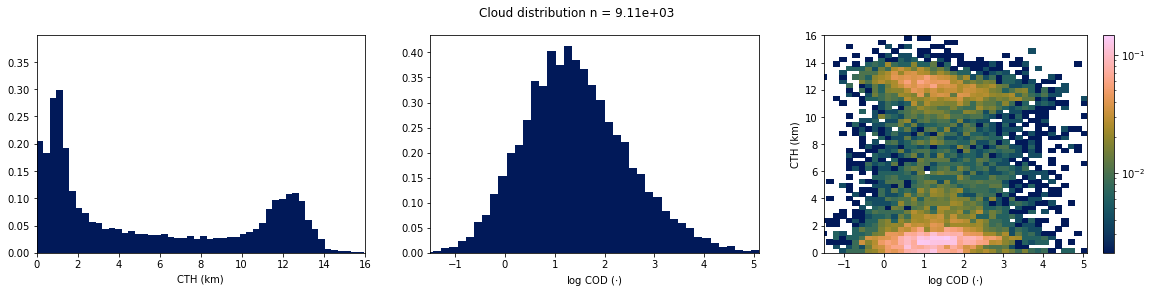

In [22]:
from palettable.cubehelix import Cubehelix
palette = Cubehelix.make(start=1, rotation=2, n=16)

dedges, hedges, freq = ds_c.dedges.data, ds_c.hedges.data, ds_c.freq.data
fig, ax = mp.plotCloudHist_f(dedges, hedges, freq,
                          title = f'Cloud distribution n = {freq.sum().sum():.2e}',
                          density = True,
#                             cmap = pal.cubehelix.perceptual_rainbow_16.mpl_colormap,
                            cmap = cmc.batlow,
                            )
fig.savefig(loc_fig + 'expl_cloud_distr.png')

# .colorbrewer.sequential import Blues_8
# ax.imshow(data, cmap=Blues_8.mpl_colormap)


In [39]:
T = T_total#.iloc[:-1]
print(T.index)
# T.columns, T.index = T.columns.astype(int), T.index.astype(int)
classes = {str(k) + '.0':v for k, v in util.ISCCP_classes.items()}
T = T.rename(
            columns = classes, 
             index = classes
            )
T

import seaborn as sns
cmap = sns.light_palette("green", as_cmap=True)

T.style.background_gradient(cmap=plt.cm.Blues)
# classes

Index(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0',
       'All'],
      dtype='object', name='from')


,clear sky,cumulus,altocumulus,cirrus,stratocumulus,altostratus,cirrostratus,stratus,nimbostratus,deep convection
from,,,,,,,,,,
clear sky,0.729418,0.169679,0.015060,0.020080,0.051707,0.006024,0.007530,0.000502,0.000000,0.000000
cumulus,0.154298,0.409503,0.109984,0.030966,0.232248,0.043780,0.016017,0.002670,0.000534,0.000000
altocumulus,0.055679,0.213808,0.314031,0.140312,0.092428,0.144766,0.035635,0.001114,0.002227,0.000000
cirrus,0.039974,0.024902,0.088467,0.655308,0.003277,0.019004,0.168414,0.000000,0.000655,0.000000
stratocumulus,0.063806,0.261999,0.037267,0.005647,0.493506,0.081875,0.010164,0.039526,0.006211,0.000000
altostratus,0.011680,0.052111,0.126685,0.018868,0.144654,0.477089,0.081761,0.015274,0.063792,0.008086
cirrostratus,0.005984,0.001496,0.025430,0.202693,0.007479,0.072550,0.604338,0.001496,0.005236,0.073298
stratus,0.033557,0.073826,0.013423,0.000000,0.583893,0.073826,0.000000,0.174497,0.040268,0.006711
nimbostratus,0.000000,0.005714,0.017143,0.000000,0.040000,0.394286,0.091429,0.040000,0.365714,0.045714


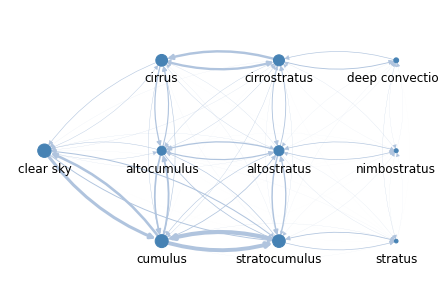

In [57]:
from itertools import combinations_with_replacement
import random
import networkx as nx

random.seed(0)

node_names = list(util.ISCCP_classes.values())[1:]
G = nx.DiGraph()
G.add_nodes_from(node_names)

for (u, v) in combinations_with_replacement(node_names, 2):
    G.add_edge(u, v, weight = T.loc[u,v])
    G.add_edge(v, u, weight = T.loc[v,u])

# for (u, v, weight) in G.edges.data('weight'):
#     print(f"Edge {u} -> {v} weights {weight}.")
    

pos = {'clear sky': np.array([-1, 1]),
         'cumulus': np.array([ 0, 0]),
         'altocumulus': np.array([0,  1]),
         'cirrus': np.array([0,  2]),
         'stratocumulus': np.array([1, 0 ]),
         'altostratus': np.array([1, 1]),
         'cirrostratus': np.array([1, 2]),
         'stratus': np.array([ 2, 0]),
         'nimbostratus': np.array([2, 1]),
         'deep convection': np.array([2, 2])}

node_size = T.loc['All'] * 1000
edge_widths = [w * T.loc['All',edge[0]] * 100 for (*edge, w) in G.edges.data('weight')] # weight * node size
labels = {item:item for item in node_names}

nx.draw(G, pos, width=edge_widths, node_size = node_size,
        edge_color = 'lightsteelblue',
        node_color = 'steelblue',
        connectionstyle='arc3, rad=.15')

pos_labels = {k: v + [0, -.2] for k, v in pos.items()}
nx.draw_networkx_labels(G, pos_labels)
plt.savefig('demo.png', transparent=True)

In [45]:
edge_widths = [(w * 10 , print(T.loc['All',edge[0]])) for (*edge, w) in G.edges.data('weight')]


0.17950797512841307
0.17950797512841307
0.17950797512841307
0.17950797512841307
0.17950797512841307
0.17950797512841307
0.17950797512841307
0.17950797512841307
0.17950797512841307
0.17950797512841307
0.16860412724159682
0.16860412724159682
0.16860412724159682
0.16860412724159682
0.16860412724159682
0.16860412724159682
0.16860412724159682
0.16860412724159682
0.16860412724159682
0.16860412724159682
0.08101288636568442
0.08101288636568442
0.08101288636568442
0.08101288636568442
0.08101288636568442
0.08101288636568442
0.08101288636568442
0.08101288636568442
0.08101288636568442
0.08101288636568442
0.13751464359736865
0.13751464359736865
0.13751464359736865
0.13751464359736865
0.13751464359736865
0.13751464359736865
0.13751464359736865
0.13751464359736865
0.13751464359736865
0.13751464359736865
0.15959268270703794
0.15959268270703794
0.15959268270703794
0.15959268270703794
0.15959268270703794
0.15959268270703794
0.15959268270703794
0.15959268270703794
0.15959268270703794
0.15959268270703794


# 1. Clear sky to Clear sky

In [23]:
# no exploration needed
ds_local.p_cscs

0.7294176706827309

# 2. Cloud to clear sky

In [24]:
dh = ds_local.dh
dd = ds_local.dd
mu_h = ds_local.mu_h # m
mu_d = ds_local.mu_d
n_h = len(mu_h)
n_d = len(mu_d)

ds_local.p

<xarray.DataArray 'p' (mu_h: 47, mu_d: 17)>
array([[     nan,      nan, 0.736331, ..., 1.      ,      nan,      nan],
       [     nan,      nan, 0.857941, ..., 1.      , 1.      ,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]])
Coordinates:
  * mu_h     (mu_h) float64 1e+03 1.3e+03 1.6e+03 ... 1.42e+04 1.45e+04 1.48e+04
  * mu_d     (mu_d) float64 -1.0 -0.7 -0.4 -0.1 0.2 0.5 ... 2.6 2.9 3.2 3.5 3.8

In [25]:
n = 3
n_d = 10
ind = list(np.round(np.linspace(0, n_d, n)).astype(int))
ind
np.floor(2.9)
mu_h

<xarray.DataArray 'mu_h' (mu_h: 47)>
array([ 1000.,  1300.,  1600.,  1900.,  2200.,  2500.,  2800.,  3100.,  3400.,
        3700.,  4000.,  4300.,  4600.,  4900.,  5200.,  5500.,  5800.,  6100.,
        6400.,  6700.,  7000.,  7300.,  7600.,  7900.,  8200.,  8500.,  8800.,
        9100.,  9400.,  9700., 10000., 10300., 10600., 10900., 11200., 11500.,
       11800., 12100., 12400., 12700., 13000., 13300., 13600., 13900., 14200.,
       14500., 14800.])
Coordinates:
  * mu_h     (mu_h) float64 1e+03 1.3e+03 1.6e+03 ... 1.42e+04 1.45e+04 1.48e+04

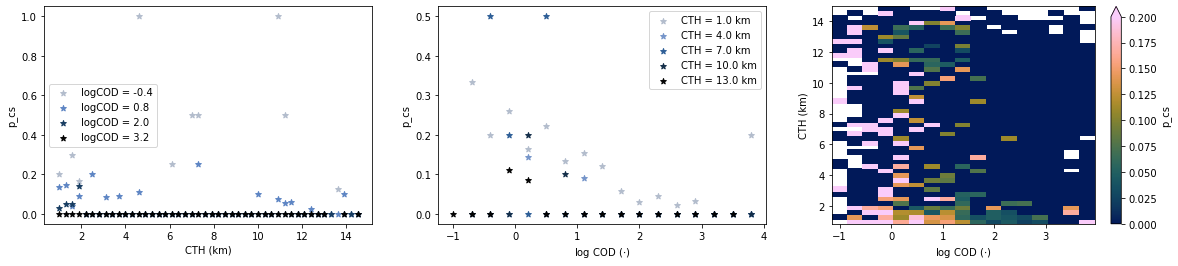

In [27]:
# fig, ax = mp.plotLocalParam(ds_local.n_bin, logscale = True)
# fig.savefig(loc_fig + 'expl_local_n_bin.png')

# fig, ax = mp.plotLocalParam(ds_local.n, logscale = True)
# fig.savefig(loc_fig + 'expl_local_n.png')

fig, ax = mp.plotLocalParam(ds_local.p_cs, logscale = False, vmax = .2)
fig.savefig(loc_fig + 'expl_local_p_cs.png')

# 3. Clear sky to Cloud

<xarray.DataArray 'theta3' (cs_to_c: 11)>
array([ 0.354359,  1.815221,  0.813067, 25.047808,  1.825146,  1.435239,
        0.798619,  0.749848,  0.73024 ,  1.      ,  1.      ])
Dimensions without coordinates: cs_to_c
Attributes:
    var_names:  ['alpha', 'beta', 'alpha1', 'beta1', 'alpha2', 'beta2', 'p', ...

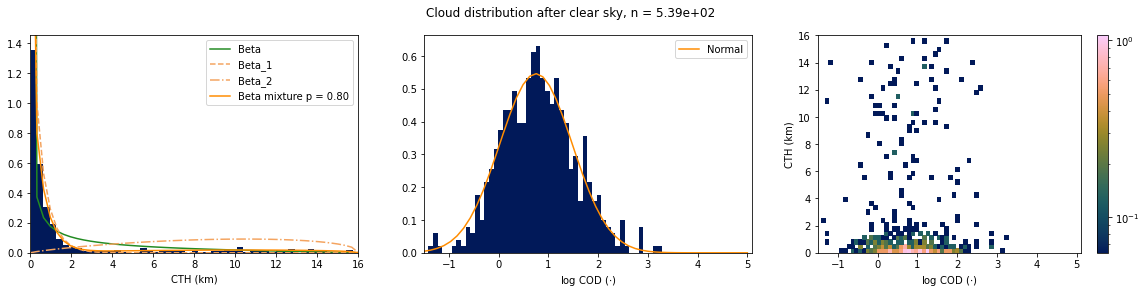

In [28]:
freq = ds_cs_c.freq.data

fig, ax = mp.plotCloudHist_f(ds_cs_c.dedges.data, ds_cs_c.hedges.data, ds_cs_c.freq.data,
                          title = f'Cloud distribution after clear sky, n = {ds_cs_c.freq.data.sum().sum():.2e}',
                         density = True)
theta = ds_theta.theta3
mp.plotCTHBeta(ax[0], *theta[0:2])
mp.plotCTHBetaMix(ax[0], *theta[2:7].data)
mp.plotCODNormal(ax[1], *theta[7:9])

fig.savefig(loc_fig + 'expl_cs_cloud_distr.png')
theta



# 4. Cloud to Cloud

1000.0 0.0
6000.0 0.0
9000.0 0.0
12000.0 0.0
1000.0 1.0
6000.0 1.0


C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:881: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:881: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))


9000.0 1.0
12000.0 1.0
1000.0 2.0


C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:881: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:881: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))


6000.0 2.0


C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:881: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:881: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))


9000.0 2.0
12000.0 2.0
1000.0 3.0


C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:881: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:881: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))


6000.0 3.0
9000.0 3.0
12000.0 3.0


C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:881: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:881: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))


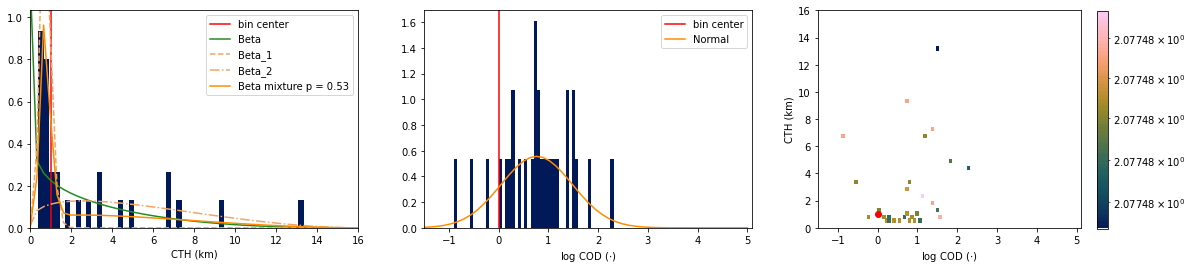

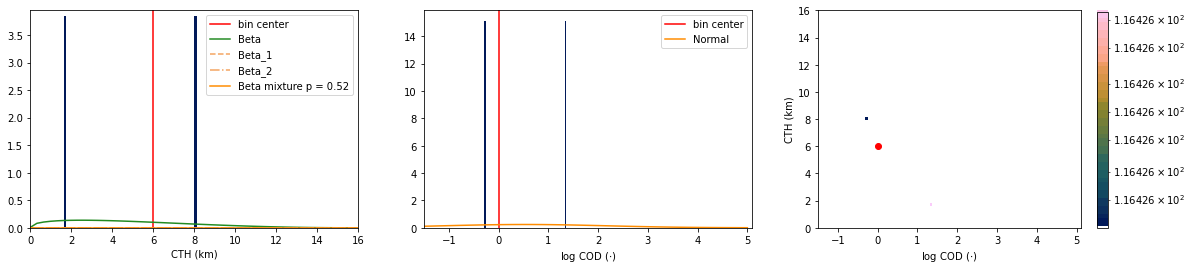

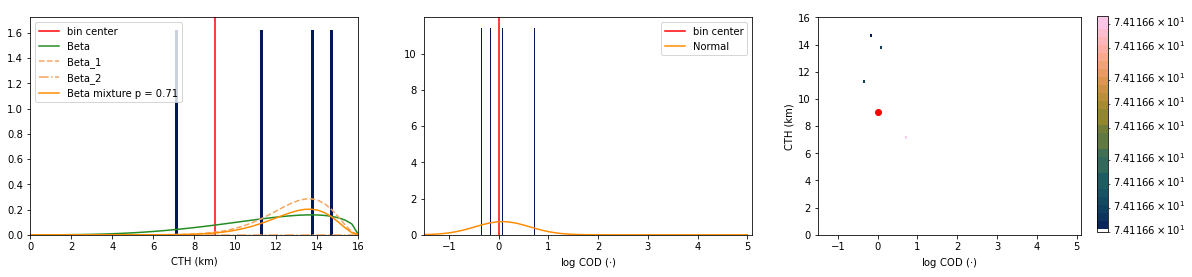

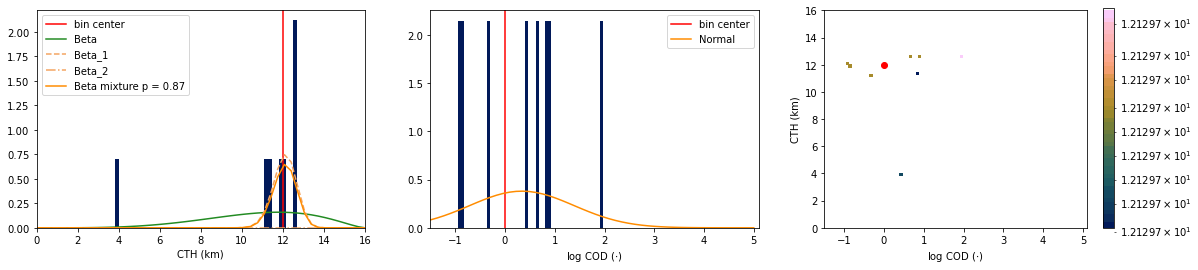

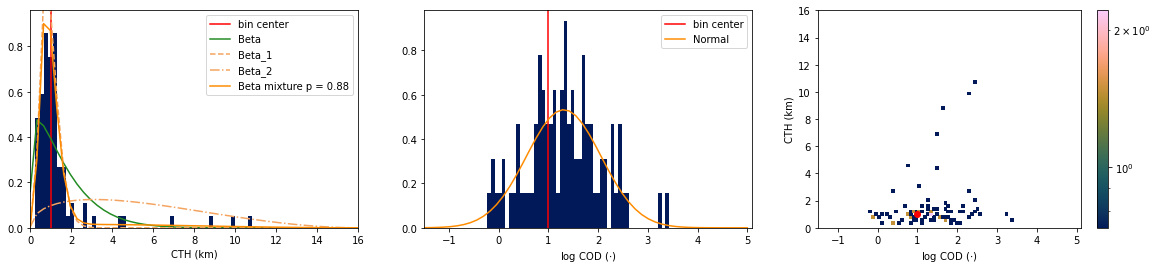

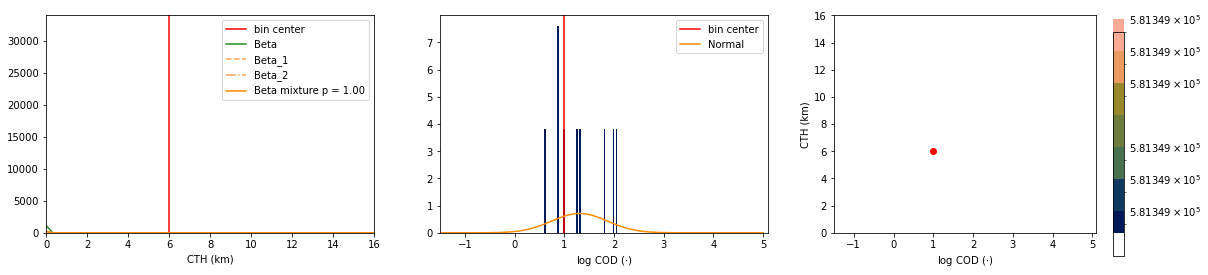

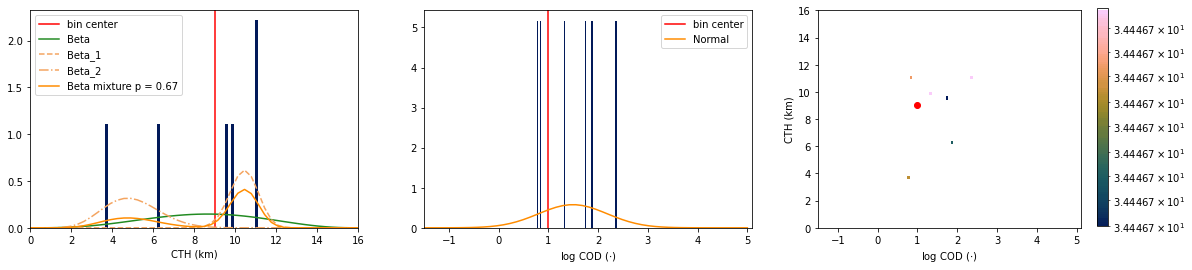

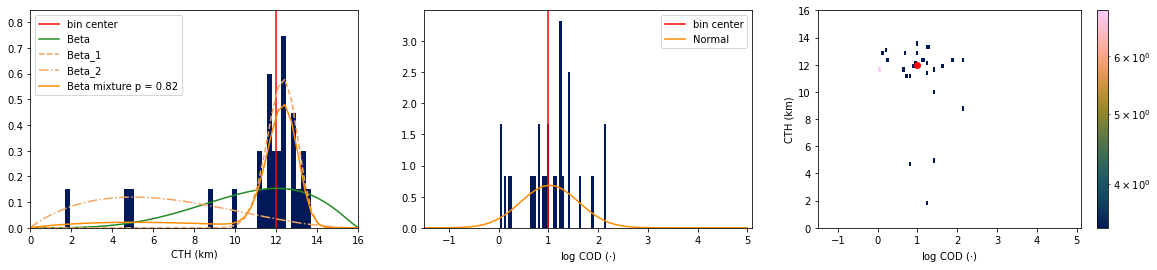

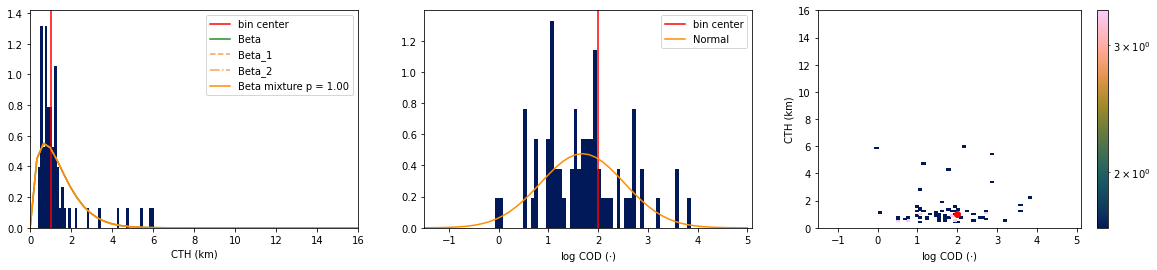

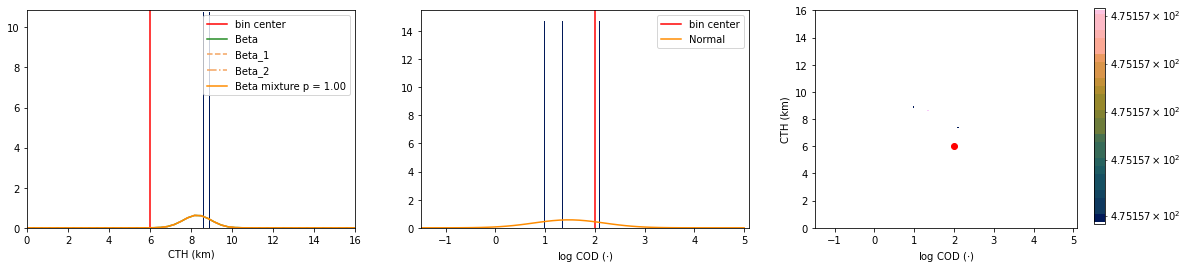

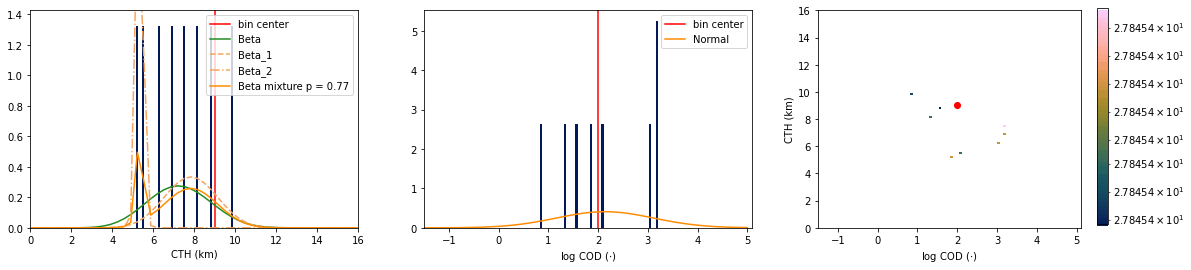

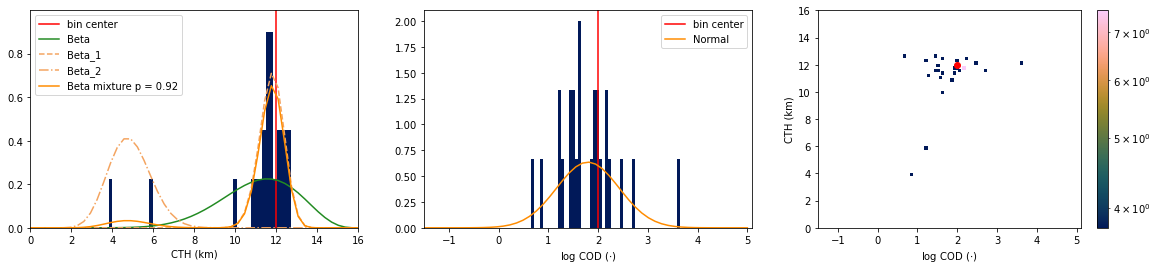

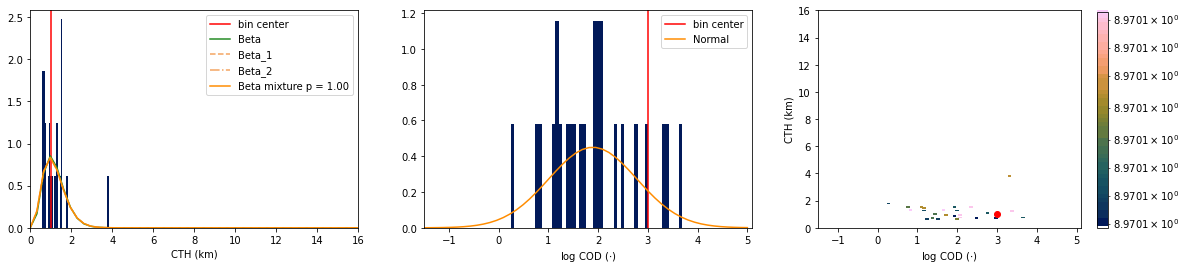

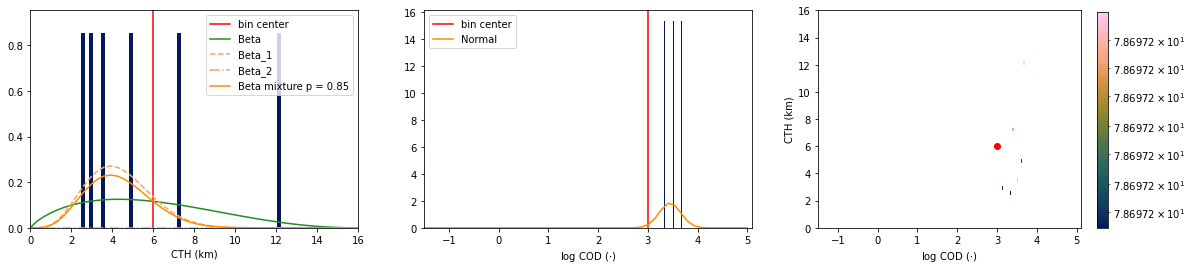

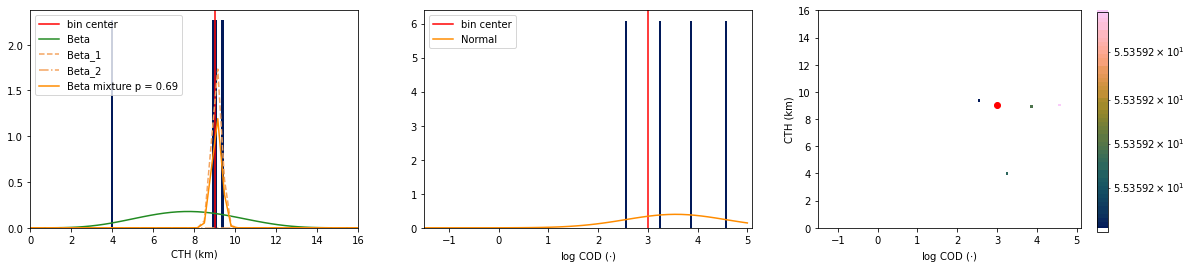

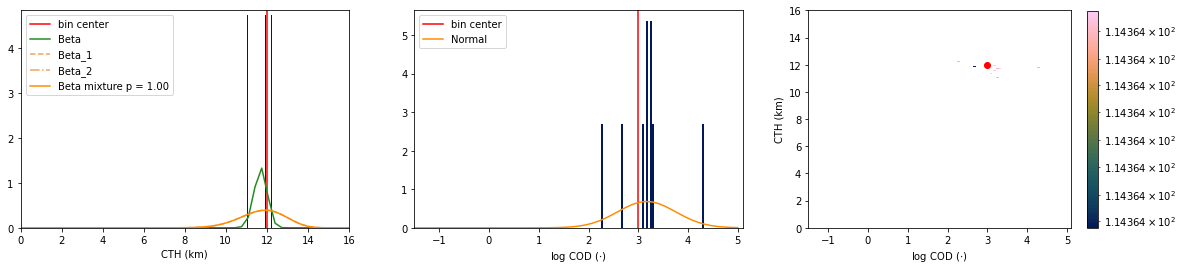

In [29]:
hlim = mp.hlim
dlim = mp.dlim

for idx, (h,d) in df_bin_fit[['bincenter_h', 'bincenter_d']].iterrows():
    df_bin = df.loc[(df.bincenter_h == h) & (df.bincenter_d == d)]
    param = df_bin_fit.loc[(df_bin_fit.bincenter_h == h) & (df_bin_fit.bincenter_d == d)]
    print(h,d)
    
    fig , ax = mp.plot_distribution_next_cloud(df_bin, ML = False, density = True) # histograms cth, cod, joint

    # bin centers
    ax[0].axvline(h*1e-3, color = 'r', label = 'bin center')
    ax[1].axvline(d, color = 'r', label = 'bin center')
    ax[2].plot(d, h*1e-3,'ro', label = 'bin center')

    # fits
    # cod
    D = np.linspace(-1.5, 5, 50)
    H = np.linspace(0, 15e3, 50)
    H_norm = ml.CTHtoUnitInt(H)

    h_beta_fit = beta(param.alpha, param.beta).pdf(H_norm)
    p = param.p.values[0] 
    
    mp.plotCTHBeta(ax[0], param.alpha, param.beta)
    mp.plotCTHBetaMix(ax[0], param.alpha1, param.beta1, param.alpha2, param.beta2, param.p.values[0])
    mp.plotCODNormal(ax[1], param.mu, param.sigma)
    
    fig.savefig(loc_fig + f'expl_bins{idx}.png')


## local behaviour parameters

## cod

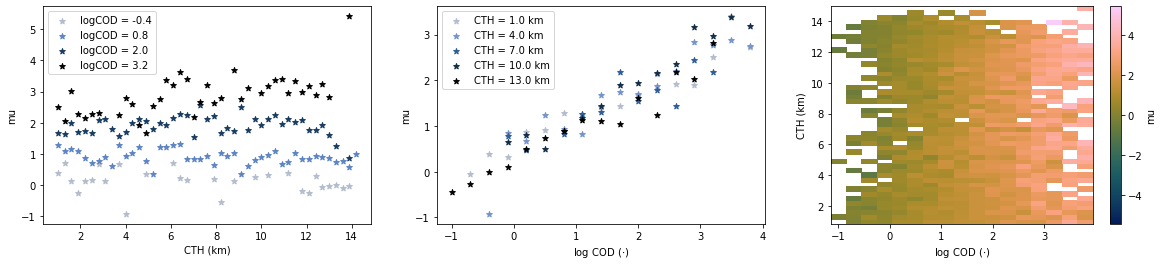

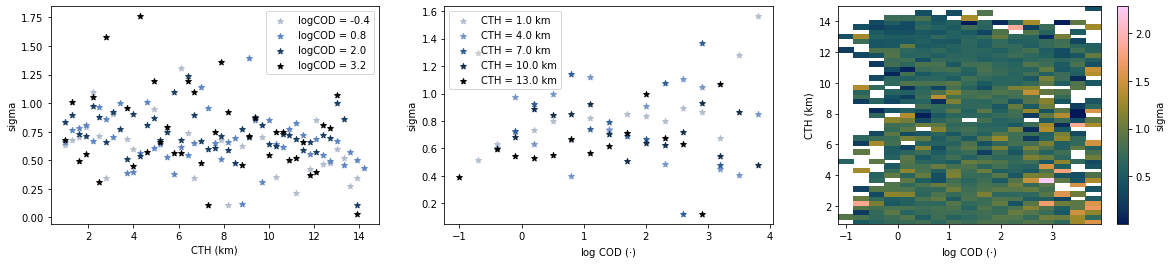

In [30]:
fig, ax = mp.plotLocalParam(ds_local.mu)
fig.savefig('../fig/model1/expl_local_mu.png')

fig, ax = mp.plotLocalParam(ds_local.sigma)
fig.savefig('../fig/model1/expl_local_sigma.png')

## CTH

C:\Users\nerin\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\nerin\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


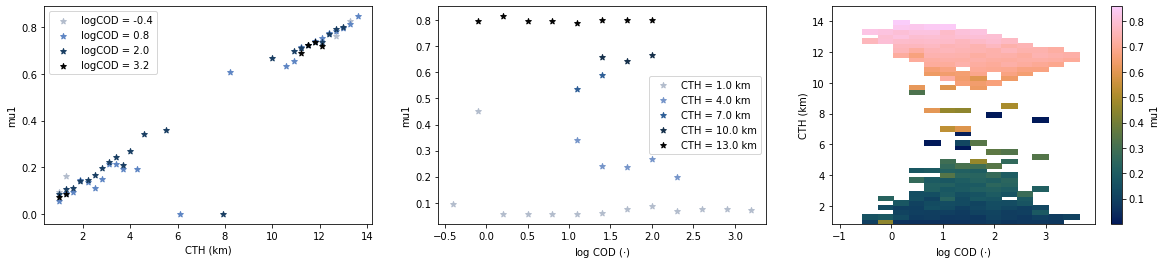

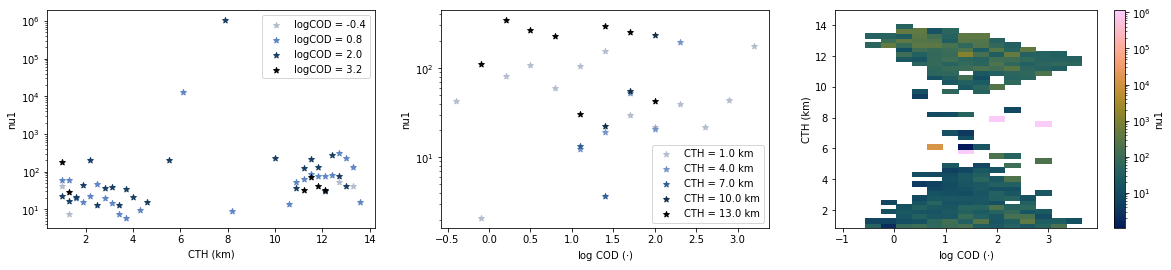

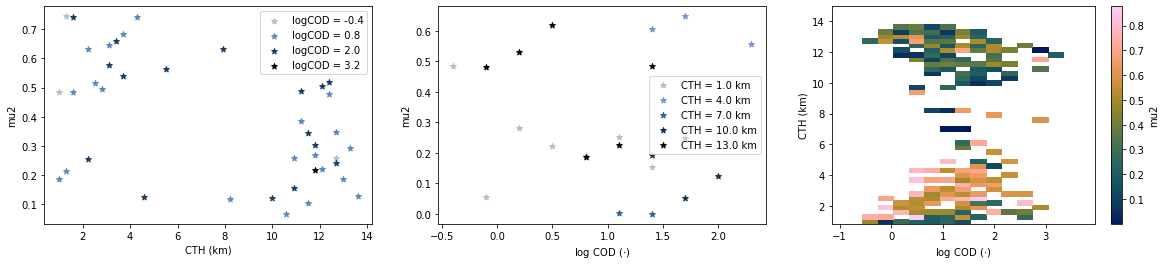

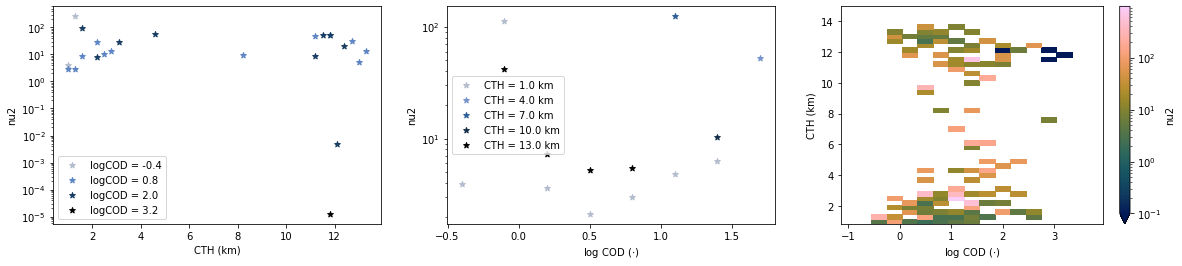

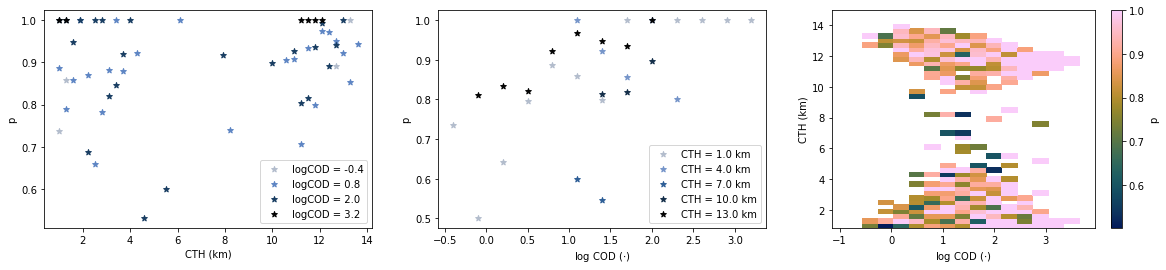

In [4]:
mu1 = me.meanBeta(ds_local.alpha1, ds_local.beta1).rename('mu1')
nu1 = (ds_local.alpha1 + ds_local.beta1).rename('nu1')
mu2 = me.meanBeta(ds_local.alpha2, ds_local.beta2).rename('mu2')
nu2 = (ds_local.alpha2 + ds_local.beta2).rename('nu2')

fig, ax = mp.plotLocalParam(mu1)
fig.savefig(loc_fig + 'expl_local_mu1.png')
fig, ax = mp.plotLocalParam(nu1, logscale = True)
fig.savefig(loc_fig + 'expl_local_nu1.png')
fig, ax = mp.plotLocalParam(mu2)
fig.savefig(loc_fig + 'expl_local_mu2.png')

nu2 = nu2.where(nu2 < 1e3)
fig, ax = mp.plotLocalParam(nu2, logscale = True, vmin = .1)
fig.savefig(loc_fig + 'expl_local_nu2.png')
fig, ax = mp.plotLocalParam(ds_local.p)
fig.savefig(loc_fig + 'expl_local_p.png')


Text(0.5, 0.98, 'Estimators of time distribution COD')

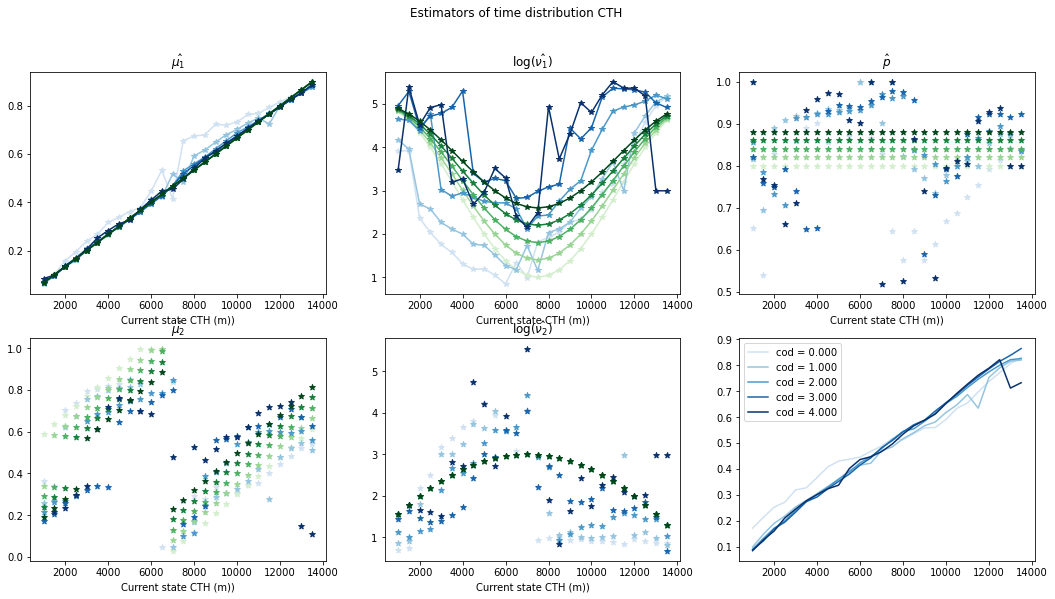

C:\Users\nerin\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


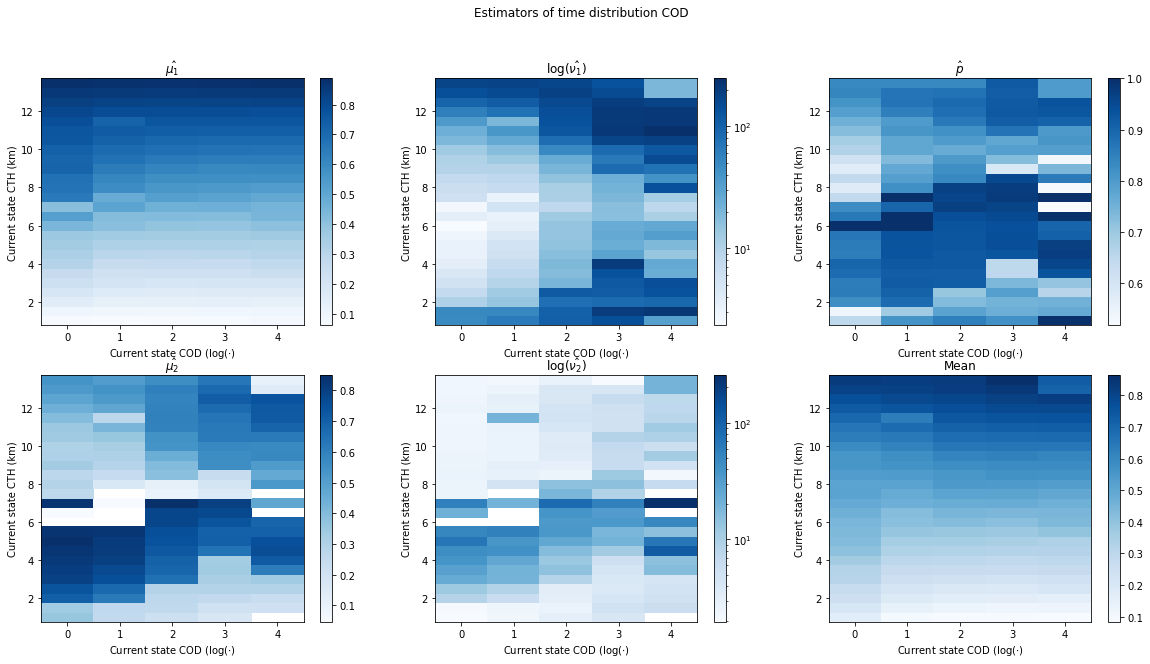

## clear sky to cloud

## cloud to clear sky